In [97]:
fidx = 'resnet34_'
midx = '0'
threshold = -1.38
print(fidx,midx,threshold)

resnet34_ 0 -1.38


In [98]:
# results from ens_oof.ipynb
mnames = ['resnet34_46']
weights = [1]
assert(len(mnames)==len(weights))
print(mnames)
print(weights)

['resnet34_46']
[1]


In [99]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

from scipy.special import logit, expit

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [100]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [101]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [102]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [103]:
test_df.columns

Index(['Predicted'], dtype='object')

In [104]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [105]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

nfold = 20

firstm = True
sumw = 0.

flat = []

for m in mnames:

    firstf = True
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for suffix in ['','a','b','c','d','e','f','g','h','i']:
            # fname = sub_dir + m + suffix + '_' + str(fold) + '_bag.pkl'
            fname = sub_dir + m + suffix + '_' + str(fold) + '.pkl'
            # print(fname)
            if os.path.exists(fname):
                print('')
                print(fname)
                idb, ptestb = pickle.load(open(fname,'rb'))
                # ptestb = np.load(fname)
                ptestb = logit(ptestb)
                
                ptestb = np.clip(ptestb,-6.0,6.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
         
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                # id = idb
                id = idx
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
                
            flat.append(np.array(ptestf).flatten())

    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,nr,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)


flat = np.transpose(np.array(flat))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.to_csv(fname)
print(fname)


./sub/resnet34_46_0.pkl
-6.0 -3.1508086 6.0
(11702, 28) -6.0 -3.1508086 6.0

./sub/resnet34_46_1.pkl
-6.0 -3.0783 6.0
(11702, 28) -6.0 -3.0783 6.0
[[1.         0.95492123]
 [0.95492123 1.        ]]

./sub/resnet34_46_2.pkl
-6.0 -3.0856829 4.956825
(11702, 28) -6.0 -3.0856829 4.956825
[[1.         0.96818488]
 [0.96818488 1.        ]]

./sub/resnet34_46_3.pkl
-6.0 -3.0479524 6.0
(11702, 28) -6.0 -3.0479524 6.0
[[1.        0.9714217]
 [0.9714217 1.       ]]

./sub/resnet34_46_4.pkl
-6.0 -3.10276 5.5849032
(11702, 28) -6.0 -3.10276 5.5849032
[[1.         0.97169604]
 [0.97169604 1.        ]]

./sub/resnet34_46_5.pkl
-6.0 -3.0689316 5.4589205
(11702, 28) -6.0 -3.0689316 5.4589205
[[1.         0.97375859]
 [0.97375859 1.        ]]

./sub/resnet34_46_6.pkl
-6.0 -3.049025 5.0698414
(11702, 28) -6.0 -3.049025 5.0698414
[[1.         0.97390468]
 [0.97390468 1.        ]]

./sub/resnet34_46_7.pkl
-6.0 -3.0950286 5.4176774
(11702, 28) -6.0 -3.0950286 5.4176774
[[1.         0.97431564]
 [0.9743156

In [106]:
test_df.columns

Index(['Predicted', 'resnet34_46'], dtype='object')

In [107]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [108]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
print(np.corrcoef(f))   

['resnet34_46']
1.0


In [109]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [110]:
weights = np.array(weights)
print(weights)

[1]


In [111]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [112]:
print(ens[1])

[-1.34534478 -3.51430368 -2.36726189 -0.74709284 -2.94204187  1.87709391 -1.30902624 -2.43386722
 -3.4190259  -5.90171242 -5.88585854 -1.77863157 -2.84937143 -2.56426024 -2.71282578 -3.96556997
 -2.74490547 -3.1808238  -2.73579931 -2.0388875  -3.30881953 -2.12558317 -2.3270936  -0.95166349
 -2.74524093 -0.55382222 -2.83931828 -4.46649837]


In [113]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [114]:
# desired class proportions from lb probing
eps = 0.004
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.004, 9: 0.004, 10: 0.004, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.004, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.004, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.004, 25: 0.222493888, 26: 0.028806584, 27: 0.004}


In [115]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold -1.38
0 0.3624 0.7378 Nucleoplasm
1 0.0438 0.0834 Nuclear membrane
2 0.0753 0.3301 Nucleoli
3 0.0593 0.1225 Nucleoli fibrillar center
4 0.0753 0.1283 Nuclear speckles
5 0.0753 0.2927 Nuclear bodies
6 0.0438 0.1037 Endoplasmic reticulum
7 0.0753 0.2962 Golgi apparatus
8 0.0040 0.0044 Peroxisomes
9 0.0040 0.0044 Endosomes
10 0.0040 0.0023 Lysosomes
11 0.0438 0.1212 Intermediate filaments
12 0.0438 0.0667 Actin filaments
13 0.0142 0.0447 Focal adhesion sites
14 0.0438 0.0840 Microtubules
15 0.0040 0.0015 Microtubule ends
16 0.0288 0.0966 Cytokinetic bridge
17 0.0142 0.0686 Mitotic spindle
18 0.0288 0.1542 Microtubule organizing center
19 0.0593 0.1877 Centrosome
20 0.0040 0.0230 Lipid droplets
21 0.1261 0.4746 Plasma membrane
22 0.0288 0.0845 Cell junctions
23 0.0753 0.2894 Mitochondria
24 0.0040 0.0259 Aggresome
25 0.2225 0.7480 Cytosol
26 0.0288 0.0594 Cytoplasmic bodies
27 0.0040 0.0002 Rods & rings


In [116]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5, -5, 101)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%3.1f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.8 0.3624 0.3628 Nucleoplasm
1 -0.4 0.0438 0.0459 Nuclear membrane
2 0.8 0.0753 0.0789 Nucleoli
3 -0.8 0.0593 0.0646 Nucleoli fibrillar center
4 -0.9 0.0753 0.0778 Nuclear speckles
5 -0.1 0.0753 0.0786 Nuclear bodies
6 -0.7 0.0438 0.0457 Endoplasmic reticulum
7 0.2 0.0753 0.0799 Golgi apparatus
8 -1.3 0.0040 0.0042 Peroxisomes
9 -1.3 0.0040 0.0040 Endosomes
10 -1.9 0.0040 0.0042 Lysosomes
11 -0.3 0.0438 0.0443 Intermediate filaments
12 -1.0 0.0438 0.0441 Actin filaments
13 -0.2 0.0142 0.0148 Focal adhesion sites
14 -0.1 0.0438 0.0448 Microtubules
15 -1.9 0.0040 0.0041 Microtubule ends
16 -0.6 0.0288 0.0292 Cytokinetic bridge
17 -0.2 0.0142 0.0155 Mitotic spindle
18 -0.1 0.0288 0.0326 Microtubule organizing center
19 -0.3 0.0593 0.0619 Centrosome
20 -0.3 0.0040 0.0042 Lipid droplets
21 0.3 0.1261 0.1357 Plasma membrane
22 -0.5 0.0288 0.0316 Cell junctions
23 0.5 0.0753 0.0788 Mitochondria
24 1.6 0.0040 0.0042 Aggresome
25 0.5 0.2225 0.2445 Cytosol
26 -0.8 0.0288 0.0293 Cytoplasmic bo

In [117]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [118]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.6708254999145444 7.0


In [119]:
print(sum(xps==0)/pred.shape[0])

0.03443855751153649


In [120]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 5
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1 5
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 19 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '3 5', '0 5 25', '0', '23'

In [121]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/resnet34_0.csv


In [122]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4245 prop 0.3628
1 Nuclear membrane count 537 prop 0.0459
2 Nucleoli count 923 prop 0.0789
3 Nucleoli fibrillar center count 756 prop 0.0646
4 Nuclear speckles count 910 prop 0.0778
5 Nuclear bodies count 920 prop 0.0786
6 Endoplasmic reticulum count 535 prop 0.0457
7 Golgi apparatus count 935 prop 0.0799
8 Peroxisomes count 49 prop 0.0042
9 Endosomes count 47 prop 0.0040
10 Lysosomes count 49 prop 0.0042
11 Intermediate filaments count 518 prop 0.0443
12 Actin filaments count 516 prop 0.0441
13 Focal adhesion sites count 173 prop 0.0148
14 Microtubules count 524 prop 0.0448
15 Microtubule ends count 48 prop 0.0041
16 Cytokinetic bridge count 342 prop 0.0292
17 Mitotic spindle count 181 prop 0.0155
18 Microtubule organizing center count 382 prop 0.0326
19 Centrosome count 724 prop 0.0619
20 Lipid droplets count 49 prop 0.0042
21 Plasma membrane count 1588 prop 0.1357
22 Cell junctions count 370 prop 0.0316
23 Mitochondria count 922 prop 0.0788
24 Aggresome count 49 

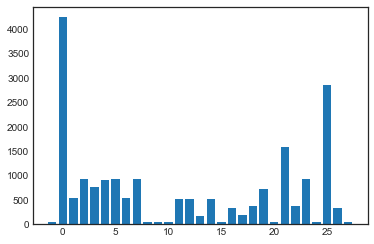

In [123]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [124]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [125]:
f1_sub(fname,'sub/protein_classification.csv')

0.7659111079071934

In [126]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5715851920586112

In [127]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5589902824409599

In [128]:
f1_sub(fname,'sub/se_resnext5.csv')

0.5990452255556317

In [129]:
f1_sub('sub/protein_classification_10.csv','sub/protein_classification.csv')

0.7602997051065691

In [130]:
f1_sub('sub/protein_classification_19.csv','sub/protein_classification.csv')

0.7602997051065691

In [131]:
f1_sub('sub/protein_classification_10.csv','sub/protein_classification_19.csv')

1.0

In [132]:
f1_sub('bojan/submit_InceptionV3.csv','sub/submit_InceptionV3.csv')

0.6432439747575565

In [133]:
f1_sub('bojan/inceptionv3_2.csv','sub/submit_InceptionV3.csv')

0.5987392720028134

In [134]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_1.csv')

0.4642857142857143

In [135]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_2.csv')

0.1426221052396753

In [136]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','sub/submit_InceptionV3.csv')

0.5918623923200268

In [137]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','bojan/inceptionresnetv2_1.csv')

0.6575760350950599